In [3]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
import time
import pandas as pd
from scipy.spatial.distance import dice
from utils import plot3, padd_images_to_max, register_image, plot1, print_img_info, resample2target, convert_itk_to_nda, convert_nda_to_itk, remap_labels
from models.EM import ExpectationMaximization
from tqdm import tqdm
import monai
from monai.metrics import HausdorffDistanceMetric
import seaborn as sns

In [4]:
train_path = Path().resolve()/'data/Training_Set/'
val_path = Path().resolve()/'data/Validation_Set'
test_path = Path().resolve()/'data/Test_Set'

pd_val_path = Path().resolve() / 'proc_data/Validation_Set/'
pd_train_path = Path().resolve() / 'proc_data/Training_Set/'
pd_test_path = Path().resolve() / 'proc_data/Test_Set/'

unet_exps = Path().resolve() / 'unet_results/'

In [5]:
def multi_atlass(val_set, weight_by=None, power=3):
    # create image placeholders for atlases propagations
    val_img = sitk.ReadImage(str(val_set/f'{val_set.name}.nii.gz'))
    val_img = sitk.Cast(val_img, sitk.sitkFloat64)
    val_segmentation = sitk.ReadImage(str(val_set/f'{val_set.name}_seg.nii.gz'))
    
    
    mean_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    mean_atlas.CopyInformation(val_img)
    
    csf_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    csf_atlas.CopyInformation(val_img)
    wm_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    wm_atlas.CopyInformation(val_img)
    gm_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    gm_atlas.CopyInformation(val_img)

    
    # read registration metrics and create weights based on them
    reg_metrics = pd.read_csv(val_set/'results/registration_results.csv')
    
    # need to flip the sign of this metric back to positive
    # so the higher the value of the metric the higher is the weight
    reg_metrics['joint_hist_mi'] = -reg_metrics['joint_hist_mi']
    reg_metrics['mattes_mi'] = -reg_metrics['mattes_mi']
    reg_metrics['correlation'] = -reg_metrics['correlation']

    # need to invert mse so smaller values are result in higher weights
    reg_metrics['mse'] = 1/reg_metrics['mse']
    
    if weight_by is not None:
        reg_metrics = {k:v**power for k,v in reg_metrics[['train_img', weight_by]].values}
    else:
        # if no weight is given, all atlases are equally weighted
        reg_metrics = {k:1 for k in reg_metrics['train_img'].values}
    # normalize the weights to sum to 1
    reg_metrics = {k:v/np.sum(list(reg_metrics.values())) for k, v in reg_metrics.items()}
    
    total_atlases = 0
    for reg_train in (val_set/'results').iterdir():
        if reg_train.is_dir():
            total_atlases+=1
            reg_segm = sitk.ReadImage(str(reg_train/f'{reg_train.name}_seg_reg.nii.gz'))

            csf_atlas = csf_atlas + resample2target(reg_segm == 1, val_img)*reg_metrics[reg_train.name]
            wm_atlas = wm_atlas + resample2target(reg_segm == 2, val_img)*reg_metrics[reg_train.name]
            gm_atlas = gm_atlas + resample2target(reg_segm == 3, val_img)*reg_metrics[reg_train.name]
            
    
    prb_atlas = np.asarray([sitk.GetArrayFromImage(csf_atlas),
                            sitk.GetArrayFromImage(wm_atlas),
                            sitk.GetArrayFromImage(gm_atlas)])
    discr_map = np.argmax(prb_atlas, axis=0) + 1
    
    discr_map[sitk.GetArrayFromImage(val_img) == 0] = 0
    discr_map = sitk.GetImageFromArray(discr_map.astype(np.int16))
    discr_map.CopyInformation(val_img)
    
    
    return discr_map, prb_atlas, val_segmentation, reg_metrics, val_img

In [117]:
def compute_avd(discr_map, val_segmentation):
    """Compute the average volume difference between the segmentation and the atlas

    Args:
        discr_map (sitk.Image): Multi-atlas segmentation
        val_segmentation (sitk.Image): Ground truth segmentation

    Returns:
        float: Average (absolute) volume difference
    """

    # compute the volume of each class in the segmentation
    seg_vol = np.bincount(sitk.GetArrayFromImage(val_segmentation).flatten())
    # compute the volume of each class in the atlas
    atlas_vol = np.bincount(sitk.GetArrayFromImage(discr_map).flatten())
    # compute the difference between the volumes
    vol_diff = np.abs(seg_vol - atlas_vol)
    # compute the average difference
    avd = np.mean(vol_diff[1:])/np.mean(seg_vol[1:])

    return avd

def expand_dims_monai(img: sitk.Image):
    """From a single volume containing segmentation labels (0: background, 1: CSF, 2: GM, 3: WM),
    generate a 4D volume with 4 channels, each channel containing a binary mask for a specific label.
    It includes a batch dimension, so the output is a 5D volume.

    Args:
        img (sitk.Image): 3D volume containing segmentation labels

    Returns:
        np.ndarray: Output 5D volume
    """
    y_pred = convert_itk_to_nda(img)
    y_pred_n = np.zeros((4, *y_pred.shape))
    for i in range(4):
        y_pred_n[i] = y_pred == i
    y_pred_n = np.expand_dims(y_pred_n, axis=0)
    return y_pred_n

def compute_hd(discr_map: sitk.Image, val_segmentation: sitk.Image):
    """Compute the Hausdorff distance between the segmentation and the atlas

    Args:
        discr_map (sitk.Image): Multi-atlas segmentation
        val_segmentation (sitk.Image): Ground truth segmentation

    Returns:
        np.ndarray: Hausdorff distances for each class. Indexes are: 0: CSF, 1: GM, 3: WM
    """
    y = expand_dims_monai(val_segmentation)
    y_pred = expand_dims_monai(discr_map)
    hdists = monai.metrics.compute_hausdorff_distance(y_pred, y, percentile=95).numpy()
    
    return hdists

In [174]:
results_unet = []
for exp_name in unet_exps.iterdir():
    # case_exp = []
    if exp_name.is_dir():
        # print(exp_name)
        for case in exp_name.iterdir():
            if case.name == 'results.csv':
                continue
            img_seg = sitk.ReadImage(str(case))
            val_segmentation = sitk.ReadImage(str(val_path/(str(case.name).split('_')[0] + '_' + str(case.name).split('_')[1])/case.name))
            scores = ExpectationMaximization.compute_dice(convert_itk_to_nda(val_segmentation), convert_itk_to_nda(img_seg))
            scores = {'CSF':  scores['ds_csf'],
                        'GM': scores['ds_gm'],
                        'WM': scores['ds_wm'],
                        'AVG': np.mean(list(scores.values()))}
            # scores = compute_hd(img_seg, val_segmentation)[0]
            # scores = {'CSF':  scores[0],
            #             'GM': scores[1],
            #             'WM': scores[2],
            #             'AVG': np.mean(scores)}
            # scores = compute_avd(img_seg, val_segmentation)
            # scores = {'AVD': scores}
            dice_list = []
            for key, value in scores.items():
                ds_scores = {}
                ds_scores['DSC'] = value
                ds_scores['type'] = key
                ds_scores['exp_name'] = exp_name.name
                ds_scores['case'] = str(case.name).split('_')[0] + '_' + str(case.name).split('_')[1]
                dice_list.append(ds_scores)
            # dict_scores['avd'] = compute_avd(img_seg, val_segmentation)
            # hdists = compute_hd(img_seg, val_segmentation)[0]
            # dict_scores['hd_csf'] = hdists[0]
            # dict_scores['hd_gm'] = hdists[1]
            # dict_scores['hd_wm'] = hdists[2]
            # dict_scores['hd_avg'] = np.mean(hdists)
            # case_exp.append(dict_scores)
            results_unet.extend(dice_list)

In [179]:
results_unet = []
for exp_name in unet_exps.iterdir():
    # case_exp = []
    if exp_name.is_dir():
        # print(exp_name)
        for case in exp_name.iterdir():
            if case.name == 'results.csv':
                continue
            ds_scores = {}
            ds_scores['case'] = str(case.name).split('_')[0] + '_' + str(case.name).split('_')[1]
            img_seg = sitk.ReadImage(str(case))
            val_segmentation = sitk.ReadImage(str(val_path/(str(case.name).split('_')[0] + '_' + str(case.name).split('_')[1])/case.name))
            scores = ExpectationMaximization.compute_dice(convert_itk_to_nda(val_segmentation), convert_itk_to_nda(img_seg))
            ds_scores['CSF_DSC'] = scores['ds_csf']
            ds_scores['GM_DSC'] = scores['ds_gm']
            ds_scores['WM_DSC'] = scores['ds_wm']
            ds_scores['Avg_DSC'] = np.mean(list(scores.values()))
            scores = compute_hd(img_seg, val_segmentation)[0]
            ds_scores['CSF_HD'] = scores[0]
            ds_scores['GM_HD'] = scores[1]
            ds_scores['WM_HD'] = scores[2]
            ds_scores['Avg_HD'] = np.mean(scores)
            ds_scores['AVD'] = compute_avd(img_seg, val_segmentation)
            scores = {'AVD': scores}            
            results_unet.append(ds_scores)

In [180]:
results_unet = pd.DataFrame(results_unet)
results_unet

,case,CSF_DSC,GM_DSC,WM_DSC,Avg_DSC,CSF_HD,GM_HD,WM_HD,Avg_HD,AVD
0,IBSR_11,0.904773,0.928886,0.941080,0.924913,1.000000,1.000000,1.000000,1.000000,0.051593
1,IBSR_12,0.920482,0.930342,0.934870,0.928565,1.414214,1.414214,1.000000,1.276142,0.028495
2,IBSR_13,0.891865,0.938939,0.921679,0.917495,1.000000,1.732051,1.000000,1.244017,0.052804
3,IBSR_14,0.931628,0.947010,0.938771,0.939136,1.000000,1.414214,1.000000,1.138071,0.027246
4,IBSR_17,0.940376,0.941587,0.920290,0.934084,1.000000,1.414214,1.414214,1.276142,0.011502


In [181]:
results_unet.to_csv('results_unet.csv', index=False)

In [175]:
results_unet = pd.DataFrame(results_unet)
results_unet['exp_name'].replace({'unet3p_augm_focal_64-32_05_synthseg': '5a',
                                    'unet3p_augm_focal_64-32_05_synthseg_merged': '5b'}, inplace=True)
# results_unet.sort_values('exp_name', inplace=True)
# results_unet.groupby(['exp_name', 'type']).mean()

In [176]:
results_unet.groupby(['exp_name', 'type']).mean()

DSC
exp_name type          
5a       AVG   0.888994
         CSF   0.867524
         GM    0.907572
         WM    0.891886
5b       AVG   0.928839
         CSF   0.917825
         GM    0.937353
         WM    0.931338

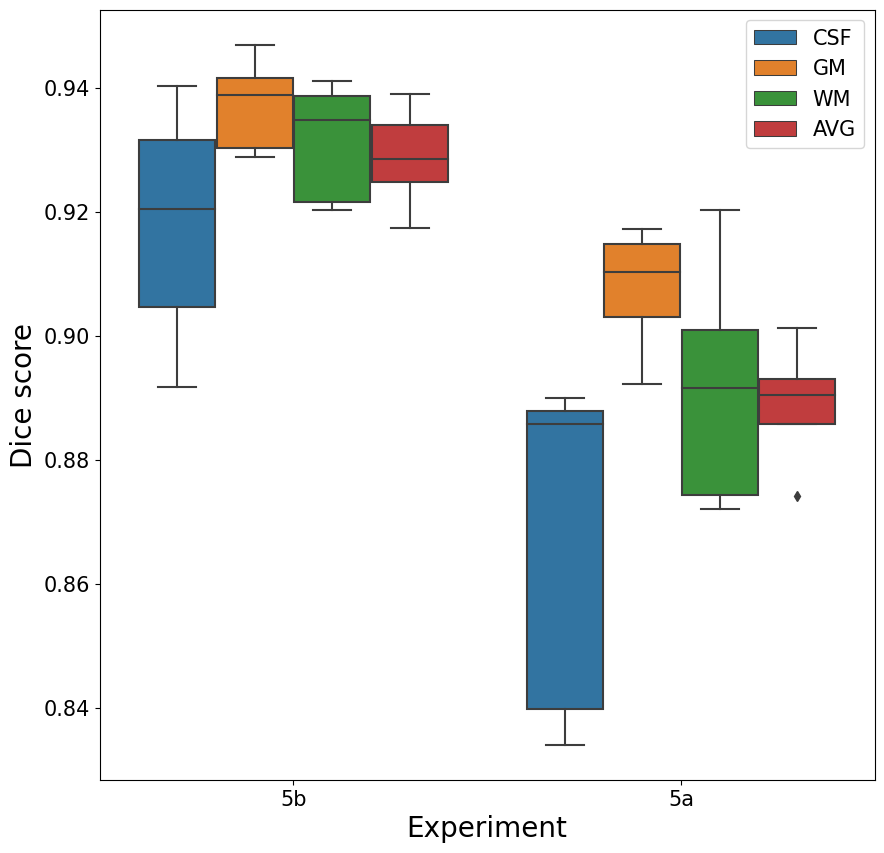

In [166]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=results_unet, x='exp_name', y='DSC', hue='type')
# plt.axhline(y=0.92, color='b', linestyle=':')
# plt.axhline(y=0.932, color='r', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Experiment', fontsize=20)
plt.ylabel('Dice score', fontsize=20)
plt.legend(fontsize=15)
plt.show()

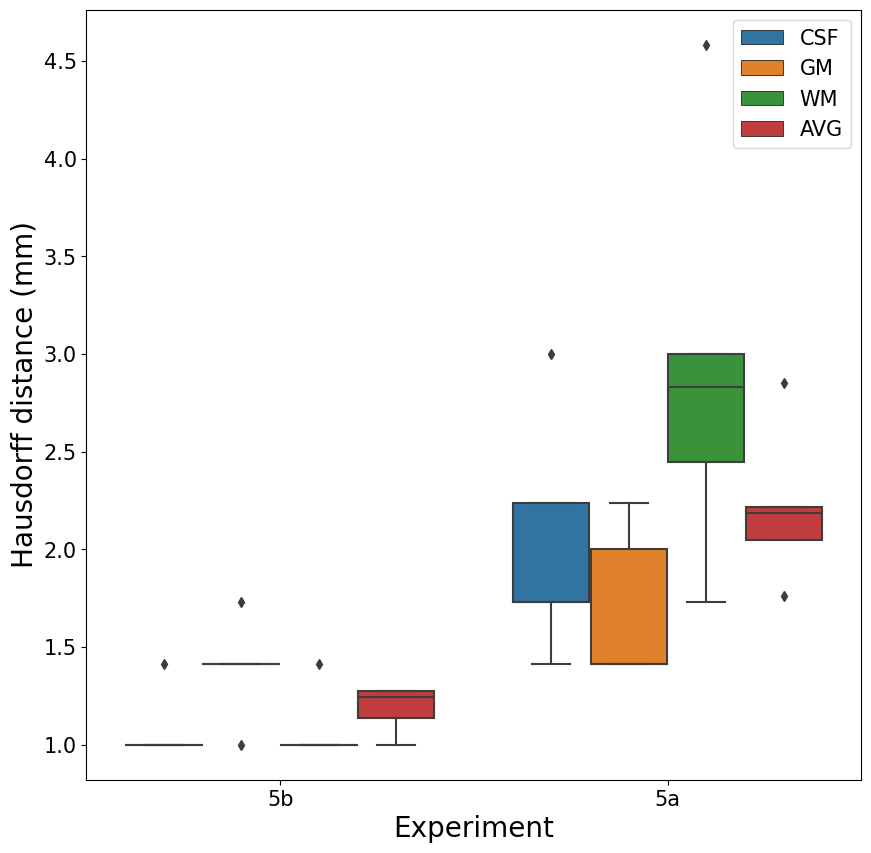

In [170]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=results_unet, x='exp_name', y='HD', hue='type')
# plt.axhline(y=0.92, color='r', linestyle=':')
# plt.axhline(y=0.9171, color='b', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Experiment', fontsize=20)
plt.ylabel('Hausdorff distance (mm)', fontsize=20)
plt.legend(fontsize=15)
plt.show()

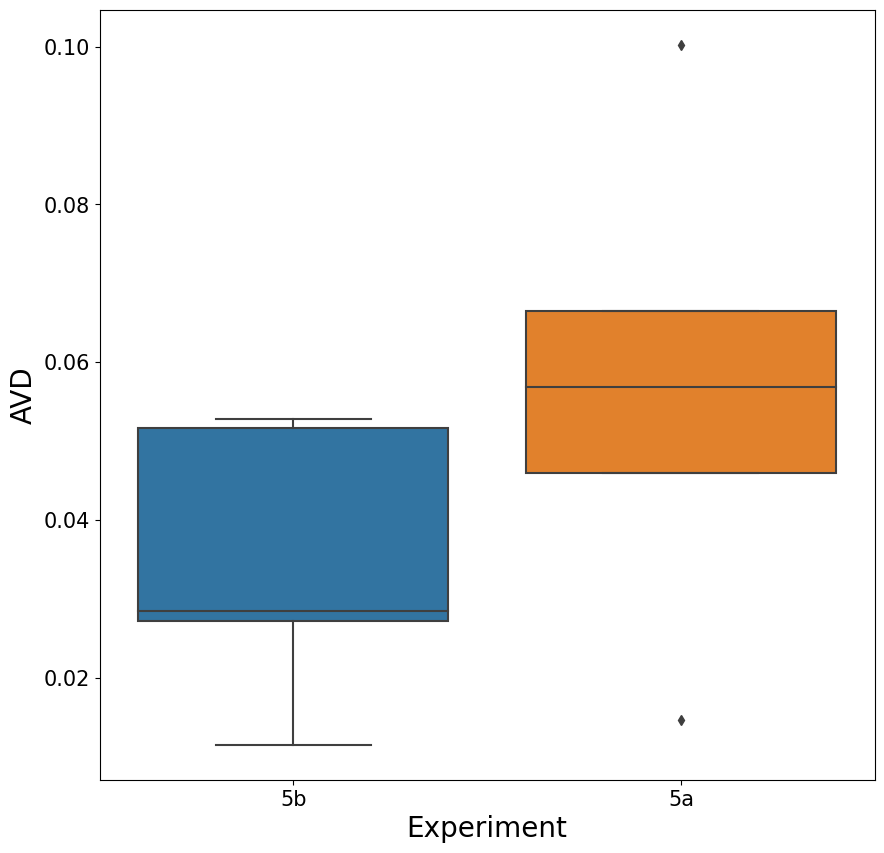

In [173]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=results_unet, x='exp_name', y='AVD') #, hue='type')
# plt.axhline(y=0.92, color='r', linestyle=':')
# plt.axhline(y=0.9171, color='b', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Experiment', fontsize=20)
plt.ylabel('AVD', fontsize=20)
# plt.legend(fontsize=15)
plt.show()

In [9]:
pd.DataFrame(results_unet)

""


In [41]:
ma_results

,ds_csf,ds_gm,ds_wm,avg_dsc,avd,hd_csf,hd_gm,hd_wm,hd_avg,weight_by,case
0,0.726490,0.827171,0.817747,0.790470,0.119438,48.836462,10.344080,8.306624,22.495722,None,IBSR_11
1,0.652745,0.820200,0.798481,0.757142,0.116826,47.979162,8.660254,10.099505,22.246307,None,IBSR_12
2,0.708636,0.857706,0.788929,0.785090,0.075200,48.590122,10.677078,12.083046,23.783416,None,IBSR_13
3,0.802023,0.867209,0.795532,0.821588,0.042302,58.395205,11.874342,10.630146,26.966564,None,IBSR_17
4,0.760526,0.862000,0.821304,0.814610,0.058780,49.537864,8.774964,9.433981,22.582270,None,IBSR_14
5,0.724053,0.826047,0.820704,0.790268,0.096770,48.836462,9.848858,8.246211,22.310510,mattes_mi,IBSR_11
6,0.634849,0.816952,0.798000,0.749934,0.118703,47.979162,8.660254,8.944272,21.861229,mattes_mi,IBSR_12
7,0.712898,0.857552,0.788637,0.786362,0.075274,48.590122,10.677078,14.525839,24.597680,mattes_mi,IBSR_13
8,0.799016,0.868430,0.796148,0.821198,0.042302,58.395205,11.874342,10.630146,26.966564,mattes_mi,IBSR_17
9,0.759005,0.861405,0.820622,0.813677,0.056884,49.537864,8.544004,9.219544,22.433804,mattes_mi,IBSR_14


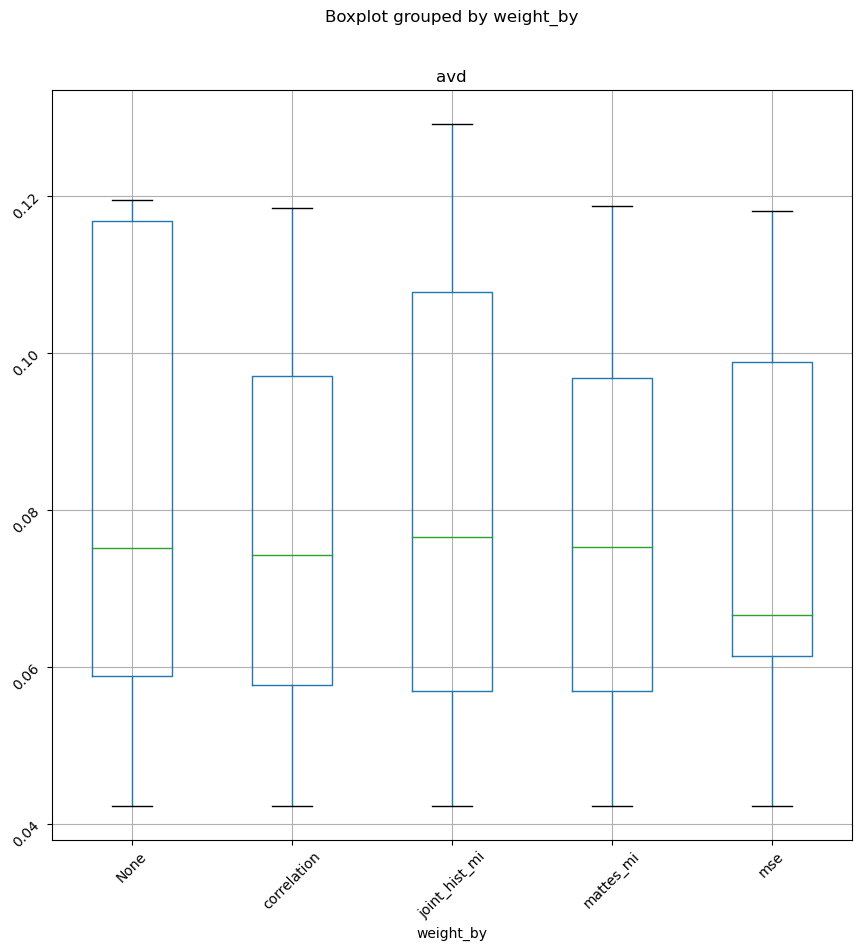

In [40]:
ma_results = pd.read_csv('results_multi_atlas_metrics.csv')
ma_results['weight_by'].replace({np.NaN: 'None'}, inplace=True)
ma_results.drop(columns=['power', 'em'], inplace=True)
ma_results
axs = ma_results.boxplot(by='weight_by', column=['avd'], figsize=(10,10), return_type='axes')
for ax in axs:
    ax.tick_params(labelrotation=45)
plt.show()

In [143]:
results_multi_atlas = []
power = 3
for w in tqdm([None, 'mattes_mi', 'joint_hist_mi', 'correlation', 'mse']):
    for val_set in val_path.iterdir():
        discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by=w, power=power)
        # scores = ExpectationMaximization.compute_dice(convert_itk_to_nda(val_segmentation), convert_itk_to_nda(discr_map))
        # scores = {'CSF':  scores['ds_csf'],
        #             'GM': scores['ds_gm'],
        #             'WM': scores['ds_wm'],
        #             'AVG': np.mean(list(scores.values()))}
        scores = compute_hd(discr_map, val_segmentation)[0]
        scores = {'CSF':  scores[0],
                    'GM': scores[1],
                    'WM': scores[2],
                    'AVG': np.mean(scores)}
        # scores = compute_avd(discr_map, val_segmentation)
        # scores = {'AVD': scores}
        dice_list = []
        for key, value in scores.items():
            ds_scores = {}
            ds_scores['HD'] = value
            ds_scores['type'] = key
            # ds_scores['exp_name'] = exp_name.name
            ds_scores['weight_by'] = w
            ds_scores['case'] = val_set.name
            dice_list.append(ds_scores)
        results_multi_atlas.extend(dice_list)
        
        
#         scores = ExpectationMaximization.compute_dice(convert_itk_to_nda(val_segmentation), convert_itk_to_nda(discr_map))
#         scores['avg_dsc'] = np.mean(list(scores.values()))
#         scores['avd'] = compute_avd(discr_map, val_segmentation)
#         hdists = compute_hd(discr_map, val_segmentation)[0]
#         scores['hd_csf'] = hdists[0]
#         scores['hd_gm'] = hdists[1]
#         scores['hd_wm'] = hdists[2]
#         scores['hd_avg'] = np.mean(hdists)
#         scores['weight_by'] = w
#         scores['power'] = power    
#         scores['case'] = val_set.name
#         scores['em'] = 'No'
#         results_multi_atlas.append(scores)
# results_multi_atlas = pd.DataFrame(results_multi_atlas)

100%|██████████| 5/5 [04:39<00:00, 55.85s/it]


In [144]:
# results_multi_atlas.sort_values(['avg_dsc', 'weight_by'], ascending=False)
results_multi_atlas = pd.DataFrame(results_multi_atlas)
results_multi_atlas['weight_by'].replace({np.NaN: 'None'}, inplace=True)
# results_multi_atlas.drop(columns=['em'], inplace=True)
results_multi_atlas

,HD,type,weight_by,case
0,36.728735,CSF,None,IBSR_11
1,3.605551,GM,None,IBSR_11
2,3.316625,WM,None,IBSR_11
3,14.550304,AVG,None,IBSR_11
4,38.069671,CSF,None,IBSR_12
...,...,...,...,...
95,14.671853,AVG,mse,IBSR_17
96,14.842472,CSF,mse,IBSR_14
97,3.464102,GM,mse,IBSR_14
98,3.162278,WM,mse,IBSR_14


In [153]:
results_multi_atlas.groupby(['case', 'weight_by']).mean()

HD
case    weight_by               
IBSR_11 None           14.550304
        correlation    14.654208
        joint_hist_mi  12.669350
        mattes_mi      14.662252
        mse            14.601662
IBSR_12 None           14.937109
        correlation    15.177250
        joint_hist_mi  13.745113
        mattes_mi      15.174039
        mse            15.051394
IBSR_13 None            4.605551
        correlation     4.606701
        joint_hist_mi   4.516657
        mattes_mi       4.582327
        mse             4.628554
IBSR_14 None            7.407499
        correlation     7.096366
        joint_hist_mi   6.809657
        mattes_mi       7.142800
        mse             7.156284
IBSR_17 None           14.818386
        correlation    14.781501
        joint_hist_mi  14.393240
        mattes_mi      14.775644
        mse            14.671853

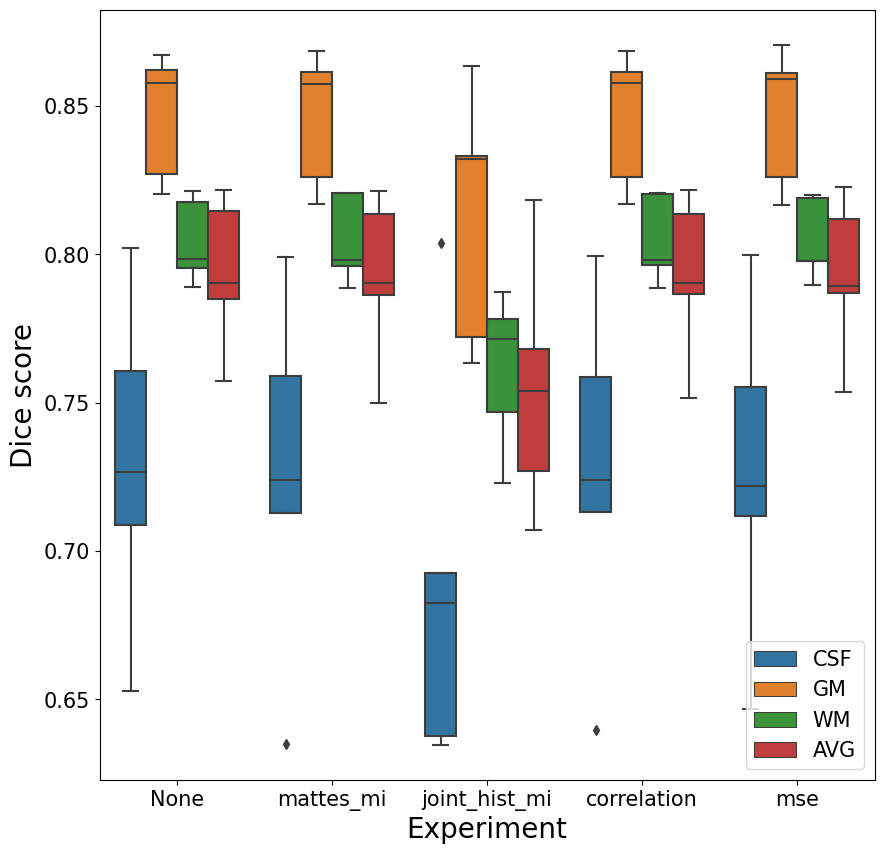

In [142]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=results_multi_atlas, x='weight_by', y='DSC', hue='type')
# plt.axhline(y=0.92, color='b', linestyle=':')
# plt.axhline(y=0.932, color='r', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Experiment', fontsize=20)
plt.ylabel('Dice score', fontsize=20)
plt.legend(fontsize=15)
# plt.grid('on')
plt.show()

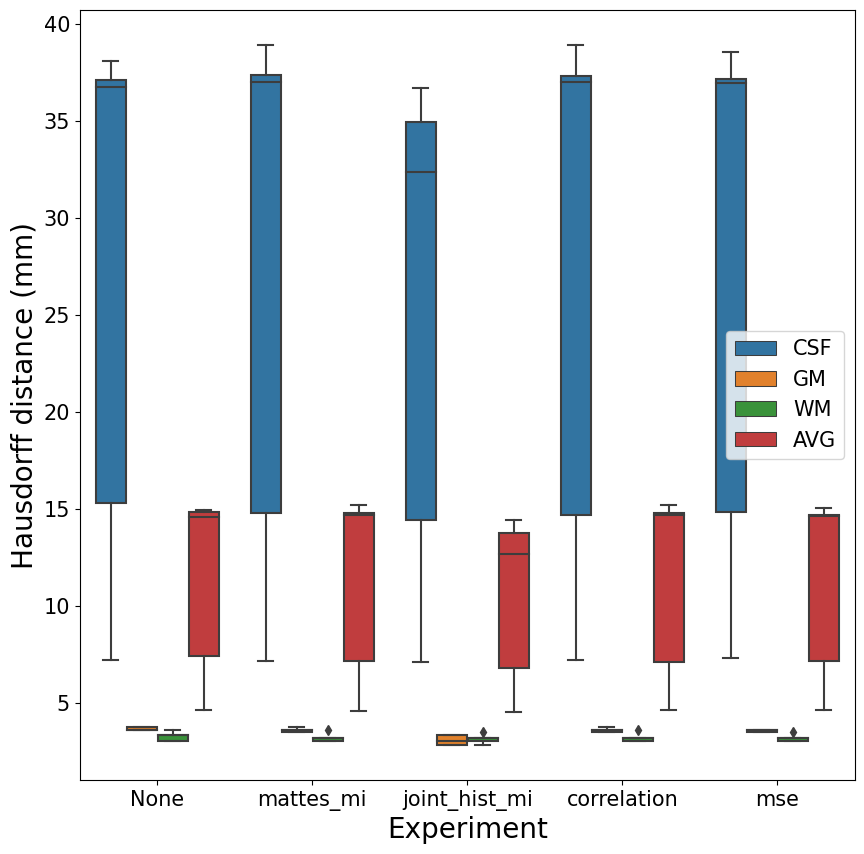

In [147]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=results_multi_atlas, x='weight_by', y='HD', hue='type')
# plt.axhline(y=0.92, color='r', linestyle=':')
# plt.axhline(y=0.9171, color='b', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Experiment', fontsize=20)
plt.ylabel('Hausdorff distance (mm)', fontsize=20)
plt.legend(fontsize=15)
plt.show()

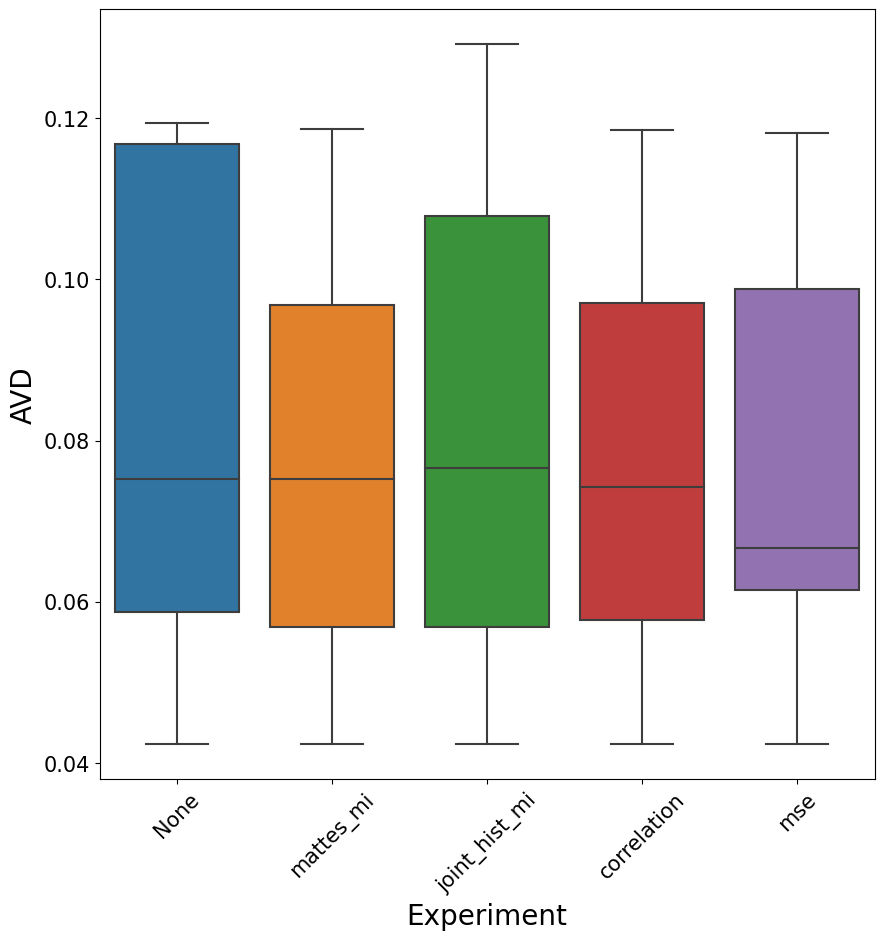

In [131]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=results_multi_atlas, x='weight_by', y='AVD') #, hue='type')
# plt.axhline(y=0.92, color='r', linestyle=':')
# plt.axhline(y=0.9171, color='b', linestyle=':')
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.xlabel('Experiment', fontsize=20)
plt.ylabel('AVD', fontsize=20)
# plt.legend(fontsize=15)
plt.show()

In [9]:
results_synthseg = []
for val_set in pd_val_path.iterdir():
    if val_set.is_dir():
        synthseg_o = sitk.ReadImage(str(val_set/f'{val_set.name}_seg_resampled.nii.gz'))
        synthseg = convert_nda_to_itk(remap_labels(convert_itk_to_nda(synthseg_o),
                                        mapping_dict={0: [0, 24], #background
                                                      1: [4, 43, 14, 15, 44, 5], #CSF
                                                      2: [3, 8, 42, 47, 10, 49, 11, 50, 13, 52, 12, 51, 17, 53, 18, 54, 26, 58, 28, 60], #GM
                                                      3: [2, 16, 7, 41, 46] #WM
                                                      }), synthseg_o)
        val_segmentation = sitk.ReadImage(str(val_path/f'{val_set.name}/{val_set.name}_seg.nii.gz'))
        scores = ExpectationMaximization.compute_dice(convert_itk_to_nda(val_segmentation), convert_itk_to_nda(synthseg))
        scores['avg_dsc'] = np.mean(list(scores.values()))
        scores['avd'] = compute_avd(synthseg, val_segmentation)
        hdists = compute_hd(synthseg, val_segmentation)[0]
        scores['hd_csf'] = hdists[0]
        scores['hd_gm'] = hdists[1]
        scores['hd_wm'] = hdists[2]
        scores['hd_avg'] = np.mean(hdists)
        scores['case'] = val_set.name
        scores['em'] = 'No'
        results_synthseg.append(scores)

In [12]:
results_synthseg = pd.DataFrame(results_synthseg)
results_synthseg

,ds_csf,ds_gm,ds_wm,avg_dsc,avd,hd_csf,hd_gm,hd_wm,hd_avg,case,em
0,0.793761,0.815082,0.901556,0.836800,0.125131,3.605551,2.000000,1.414214,2.339922,IBSR_11,No
1,0.838597,0.802037,0.857789,0.832808,0.191278,2.828427,2.236068,2.449490,2.504662,IBSR_12,No
2,0.795205,0.810595,0.829230,0.811677,0.244543,2.449490,3.000000,3.000000,2.816497,IBSR_13,No
3,0.838428,0.788932,0.827867,0.818409,0.185675,2.828427,3.316625,2.449490,2.864847,IBSR_17,No
4,0.823137,0.835315,0.869902,0.842785,0.149722,2.236068,2.449490,2.236068,2.307209,IBSR_14,No


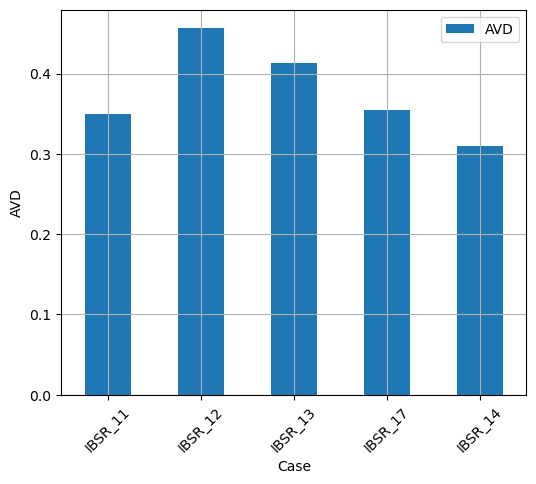

In [41]:
# results_synthseg.to_csv('results_synthseg_metrics_2.csv', index=False)
restuls_synthseg = pd.read_csv('results_synthseg_metrics_1.csv')
restuls_synthseg.drop(columns=['em'], inplace=True)
restuls_synthseg.rename(columns={'hd_avg': 'avg_HD', 'avg_dsc': 'avg_DSC', 'avd': 'AVD'}, inplace=True)

axs = restuls_synthseg.loc[:, ['AVD']].plot.bar(rot=0, figsize=(6,5))
axs.set_xticklabels(restuls_synthseg['case'], rotation=45)
axs.legend(loc=1)
# axs.set_ylim(0.6, 0.95)
# plt.title('Dice scores')
plt.ylabel('AVD')
plt.xlabel('Case')
plt.grid('on')
plt.show()

<AxesSubplot:>

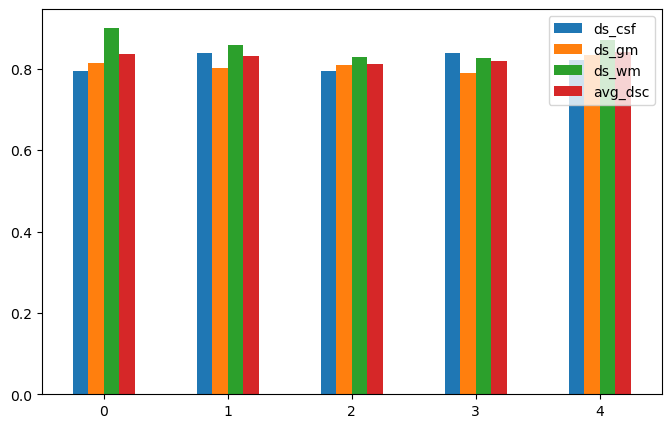

In [11]:
restuls_synthseg.loc[:, ['ds_csf', 'ds_gm', 'ds_wm', 'avg_dsc']].plot.bar(rot=0, figsize=(8,5))

### Dev

In [102]:
# calculate the average ratio per tissue type
res = []
for val_set in val_path.iterdir():
        ratios = {}
        # discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by=None, power=3)
        val_segmentation = sitk.ReadImage(str(val_set/f'{val_set.name}_seg.nii.gz'))
        ratios['case'] = val_set.name
        # ratios['csf'] = np.sum(val_segmentation == 1)/np.sum(val_segmentation != 0)
        # ratios['wm'] = np.sum(val_segmentation == 2)/np.sum(val_segmentation != 0)
        # ratios['gm'] = np.sum(val_segmentation == 3)/np.sum(val_segmentation != 0)
        # res.append(ratios)
        # print(val_set.name, val_segmentation.GetSize())
        avg, seg_counts, _ = compute_avd(val_segmentation, val_segmentation)
        print(seg_counts[1:]/seg_counts[1:].sum())
        ratios['csf'] = seg_counts[1]/seg_counts[1:].sum()
        ratios['wm'] = seg_counts[2]/seg_counts[1:].sum()
        ratios['gm'] = seg_counts[3]/seg_counts[1:].sum()
        res.append(ratios)


[0.01207084 0.58973186 0.3981973 ]
[0.01760203 0.64998299 0.33241498]
[0.01080137 0.71249515 0.27670349]
[0.01654048 0.6740671  0.30939242]
[0.01284638 0.64388344 0.34327018]


([<matplotlib.axis.XTick at 0x7fd385c60460>,
 [Text(0, 0, 'IBSR_11'),
  Text(1, 0, 'IBSR_12'),
  Text(2, 0, 'IBSR_13'),
  Text(3, 0, 'IBSR_17'),
  Text(4, 0, 'IBSR_14')])

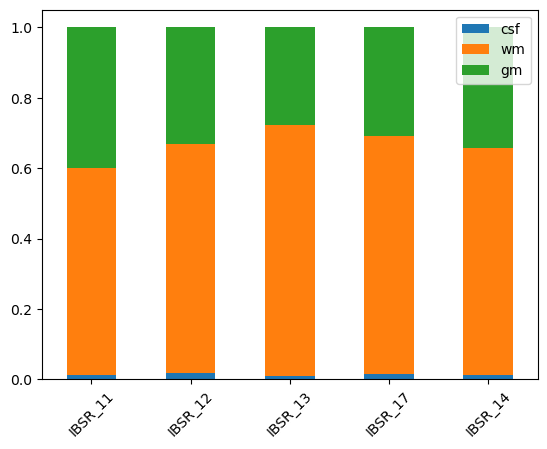

In [106]:
res = pd.DataFrame(res)
res.plot.bar(stacked=True)
plt.xticks(labels=res['case'], ticks=range(len(res['case'])), rotation=45)

In [18]:
# image for report
for val_set in val_path.iterdir():
    print(val_set)
    w = None
    power = 3
    discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by=w, power=power)
    break
sitk.WriteImage(discr_map, str(val_set/'results'/f'{val_set.name}_atlas_none.nii.gz'))

/home/alex/Documents/MAIA/udG/MISA/misa_project/brain_segmentation/data/Validation_Set/IBSR_11


In [17]:
def plot_3_images(img1, img2, img3, title1='1', title2='2', title3='3', cmap='gray'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2)
    ax3.imshow(img3, cmap=cmap)
    ax3.set_title(title3)
    plt.show()

In [6]:
# val_img = sitk.ReadImage(str(val_set/f'{val_set.name}.nii.gz'))
# val_img = sitk.Cast(val_img, sitk.sitkFloat64)
# val_segmentation = sitk.ReadImage(str(val_set/f'{val_set.name}_seg.nii.gz'))
discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by='mse', power=3)
EM = ExpectationMaximization(3, init_method='segm')
em_segm = EM.segment(images=[sitk.GetArrayFromImage(val_img).T],
                        mask=sitk.GetArrayFromImage(val_segmentation).T,
                        segmentation=sitk.GetArrayFromImage(discr_map),
                        max_iter=100000, tol=1e-7,
                    #  tissue_atlasses=prb_atlas,
                    )

-5645667.8518476775
4201.6519910739735
845.525443197228
975.4284771224484
1221.179822774604
1757.7799570910634
1307.7445269895718
1630.3901571668684
2053.575286715105
2583.850801588595
3237.1557894067837
4022.794894729182
4925.189345748164
5878.7846191022545
6745.417248461209
7322.809129851497
7412.018629740924
6918.659725501016
5910.833097581565
4595.456888060272
3243.553033095598
2096.12082745675
1279.122839316912
781.7059918239713
512.6535238113254
374.7975912079215
301.76946213878693
258.1926392426714
227.8326643878594
203.82498776409776
183.34402074851096
165.19528464861213
148.8291113190353
133.95522378385067
120.39395466893912
108.0176701363176
96.72637499719858
86.43651313763112
77.07514342982321
68.5765335481614
60.88000916317105
53.92855794988573
47.66794710662216
42.04620725288987
37.01337668970227
32.52142626568675
28.52430278789252
24.978034396283327
21.840863992460072
19.07337881438434
16.63861692585051
14.502141240239144
12.63207331560552
10.999089073762297
9.57637379914

{'CSF': 0.0, 'WM': 0.0, 'GM': 0.33742289688962773}

In [ ]:
EM.compute_dice(sitk.GetArrayFromImage(val_segmentation), em_segm)

In [47]:
val_img = sitk.ReadImage(str(val_set/f'{val_set.name}.nii.gz'))
# # val_img = sitk.Cast(val_img, sitk.sitkFloat64)
val_segmentation = sitk.ReadImage(str(val_set/f'{val_set.name}_seg.nii.gz'))
# discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by='mse', power=3)

EM = ExpectationMaximization(3, init_method='kmeans')
em_segm = EM.segment(images=[convert_itk_to_nda(val_img)],
                        mask=convert_itk_to_nda(val_segmentation),
                        max_iter=10000, tol=1e-5,
                        # segmentation=sitk.GetArrayFromImage(discr_map),
                        # tissue_atlasses=prb_atlas,
                    )

-5591449.919228224
15395.373904582113
4176.124550381675
1824.1388650955632
1001.5676860120147
4605.950014148094
1614.8128149216996
845.1233052967116
531.752167529054
373.4798814775422
282.3869841063395
225.00088661890476
186.31345968693495
158.79678089078516
138.35097318384797
122.59704274684191
110.08283235095442
99.88416273891926
91.39174838084728
84.19145606141538
77.99411158896983
72.59284623377025
67.83636658787728
63.61174354646355
59.83306660261005
56.43380471970886
53.36156693175435
50.57444346491248
48.038413886725905
45.725482772290704
43.61232192832976
41.67926683668047
39.90956890769303
38.28882979098707
36.80456935875118
35.44589243605733
34.203228392452004
33.06812632009387
32.03309050034731
31.091448547318578
30.237244192138313
29.465147211961447
28.770378972403705
28.14864880796522
27.5960998410359
27.109259044751525
26.684994442947207
26.32047487795353
26.01313286256045
25.76062725186348
25.56080851573497
25.41168303322047
25.311376550234854
25.258095905557276
25.25009

In [48]:
print(val_segmentation.GetSize())
print(em_segm.shape)

(256, 128, 256)
(128, 256, 256)


In [45]:
print(EM.compute_dice(convert_itk_to_nda(val_segmentation), em_segm, map_dict={1:1, 2:3, 3:2}))
slice=150
plot_3_images(convert_itk_to_nda(val_img)[..., slice], 
            em_segm[..., slice].T, convert_itk_to_nda(val_segmentation)[..., slice], 'o', 'em', 'gt')

ValueError: operands could not be broadcast together with shapes (256,128,256) (128,256,256) 

In [16]:
val_img = sitk.ReadImage(str(val_path.parent/'other_imgs/1003.nii.gz'))
val_segmentation = sitk.ReadImage(str(val_path.parent/'other_imgs/1003_3C.nii.gz'))
EM = ExpectationMaximization(3, init_method='kmeans')
em_segm = EM.segment(images=[sitk.GetArrayFromImage(val_img).T],
                        mask=sitk.GetArrayFromImage(val_segmentation).T,
                        max_iter=0, tol=1e-7,
                        # segmentation=sitk.GetArrayFromImage(discr_map),
                        # tissue_atlasses=prb_atlas,
                    )
EM.compute_dice(sitk.GetArrayFromImage(val_segmentation), em_segm)

{'CSF': 0.011770919434332717,
 'WM': 0.13211432617790494,
 'GM': 0.14827552799844992}

In [5]:
from scipy.stats import multivariate_normal
import numpy as np

def gmm_em(X, K, max_iter=100, tol=1e-3):
    # Initialize the model parameters
    N, D = X.shape
    mu = np.random.randn(K, D)
    Sigma = np.array([np.eye(D)] * K)
    pi = np.ones(K) / K
    
    # Initialize the responsibility matrix
    gamma = np.zeros((N, K))
    
    for i in tqdm(range(max_iter), total=max_iter):
        # Compute the responsibilities
        for k in range(K):
            gamma[:,k] = pi[k] * multivariate_normal.pdf(X, mu[k], Sigma[k])
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        
        # Update the parameters
        N_k = np.sum(gamma, axis=0)
        mu = np.dot(gamma.T, X) / N_k[:, np.newaxis]
        for k in range(K):
            Sigma[k] = np.dot((X - mu[k]).T, (X - mu[k]) * gamma[:,k][:, np.newaxis]) / N_k[k]
            pi[k] = N_k[k] / N
            
        # Check for convergence
        log_likelihood = np.sum(np.log(np.sum(gamma, axis=1)))
        if i > 0 and np.abs(log_likelihood - log_likelihood_prev) < tol:
            break
        log_likelihood_prev = log_likelihood
        
    return gamma, mu, Sigma, pi

In [7]:
val_img = convert_itk_to_nda(sitk.ReadImage(str(val_set/f'{val_set.name}.nii.gz')))
val_segmentation = convert_itk_to_nda(sitk.ReadImage(str(val_set/f'{val_set.name}_seg.nii.gz')))
X = val_img[val_segmentation != 0].reshape(-1, 1)
gamma, mu, Sigma, pi = gmm_em(X, 3, max_iter=100, tol=1e-3)
labels = np.argmax(gamma, axis=1) + 1
results = np.zeros(val_segmentation.shape)
results[val_segmentation != 0] = labels
ExpectationMaximization.compute_dice(convert_itk_to_nda(val_segmentation), results)


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_104698/1959493078.py:18: RuntimeWarning: invalid value encountered in true_divide
  gamma /= np.sum(gamma, axis=1, keepdims=True)
  1%|          | 1/100 [03:00<4:57:09, 180.10s/it]


ValueError: array must not contain infs or NaNs

In [17]:
results_multi_atlas_em = []
em = ExpectationMaximization(3)
power = 3
for w in tqdm([None, 'mattes_mi', 'joint_hist_mi', 'correlation', 'mse']):
    for val_set in val_path.iterdir():
        discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by=w, power=power)
        dsc_scores = em.compute_dice(sitk.GetArrayFromImage(val_segmentation), sitk.GetArrayFromImage(discr_map))
        dsc_scores['avg_dsc'] = np.mean(list(dsc_scores.values()))
        dsc_scores['weight_by'] = w
        dsc_scores['power'] = power
        dsc_scores['case'] = val_set.name
        dsc_scores['em'] = 'No'
        
        EM = ExpectationMaximization(3, init_method='kmeans')
        em_segm = EM.segment(images=[sitk.GetArrayFromImage(val_img)],
                             mask=sitk.GetArrayFromImage(val_img > 0),
                            #  segmentation=sitk.GetArrayFromImage(discr_map),
                            #  tissue_atlasses=prb_atlas,
                            )
        em_dsc = EM.compute_dice(sitk.GetArrayFromImage(val_segmentation), em_segm)
        print(em_dsc)
        for k, v in em_dsc.items():
            dsc_scores[f'em_{k}'] = v
        dsc_scores[f'em_avg_dsc'] = np.mean(list(em_dsc.values()))
        results_multi_atlas_em.append(dsc_scores)
        break
results_multi_atlas_em = pd.DataFrame(results_multi_atlas_em)

 20%|██        | 1/5 [00:09<00:38,  9.54s/it]

{'CSF': 0.030024152376912062, 'WM': 0.0, 'GM': 0.033109020952783126}


 40%|████      | 2/5 [00:18<00:26,  8.96s/it]

{'CSF': 0.030270666137743738, 'WM': 0.0, 'GM': 0.03581465786096913}


 60%|██████    | 3/5 [00:26<00:17,  8.82s/it]

{'CSF': 0.030270666137743738, 'WM': 0.0, 'GM': 0.03581465786096913}


 80%|████████  | 4/5 [00:35<00:08,  8.83s/it]

{'CSF': 0.0034445259614233905, 'WM': 0.0, 'GM': 0.006629395852119026}


 80%|████████  | 4/5 [00:43<00:10, 10.90s/it]


KeyboardInterrupt: 

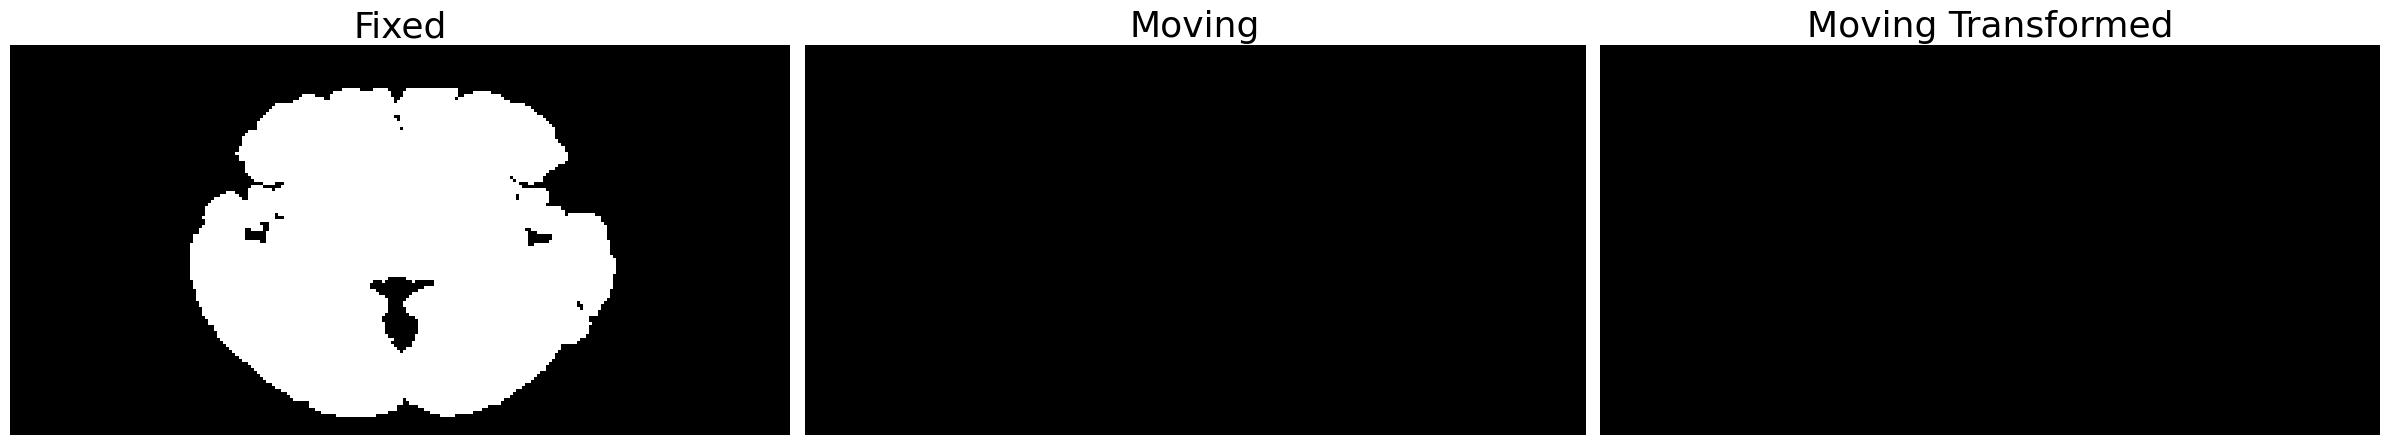

In [18]:
em_segm_sitk = sitk.GetImageFromArray(em_segm)

plot3(em_segm_sitk==1, em_segm_sitk==2, em_segm_sitk == 3)

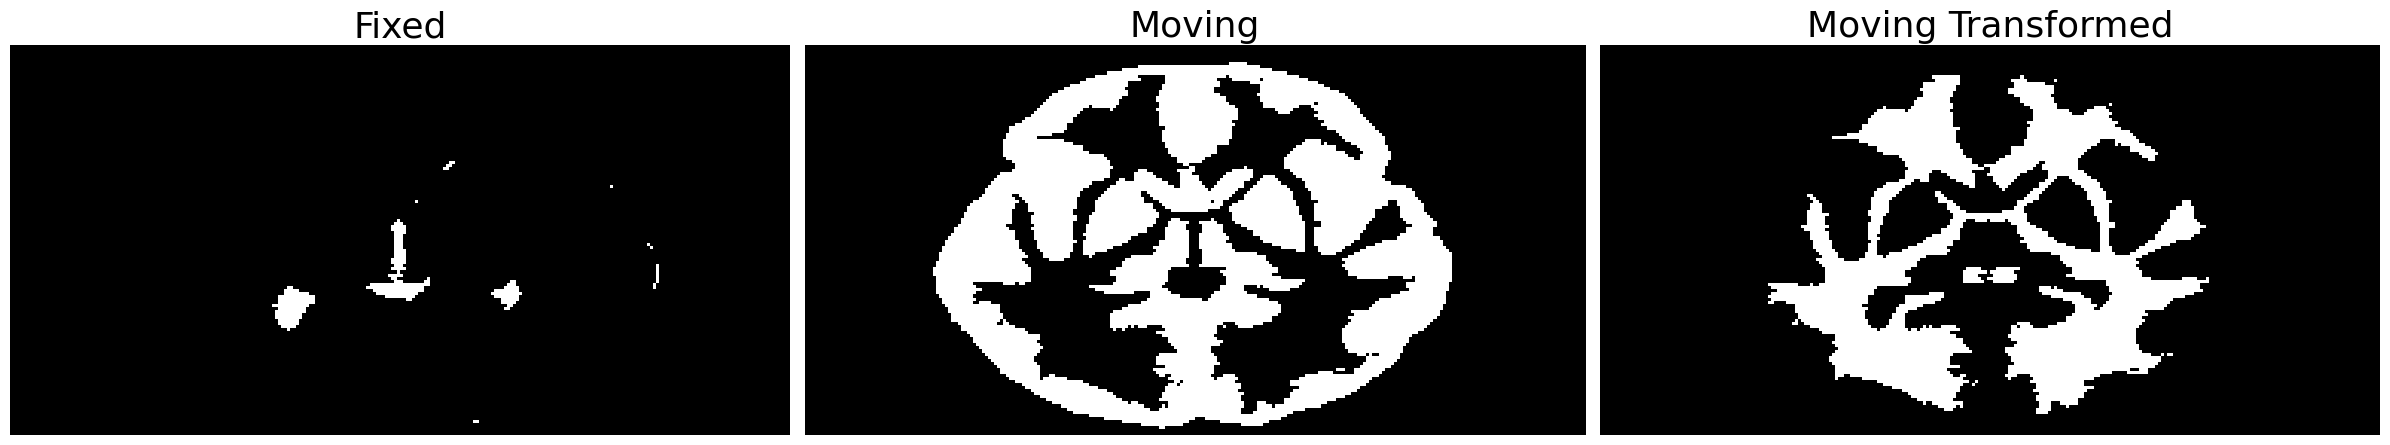

In [8]:
plot3(discr_map==1, discr_map==2, discr_map == 3)

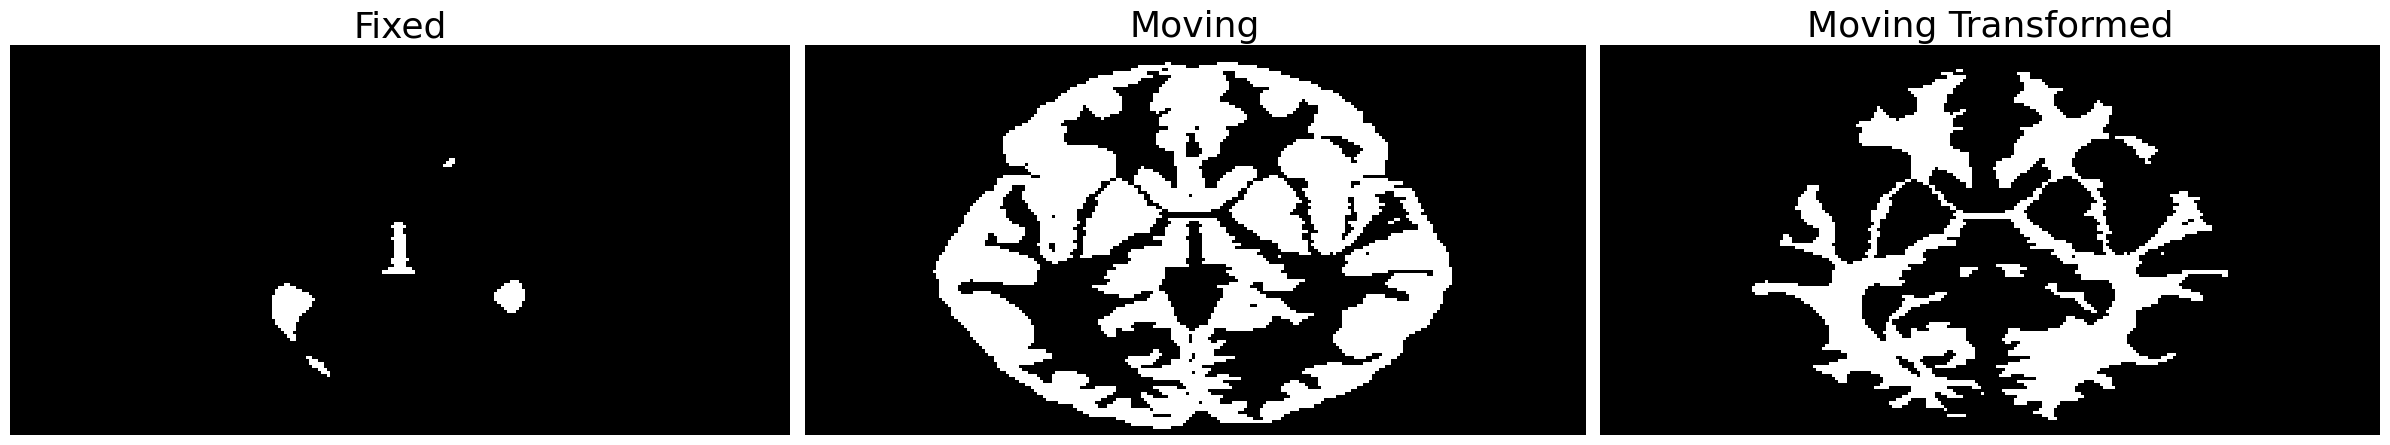

In [9]:
plot3(val_segmentation==1, val_segmentation==2, val_segmentation==3)

In [9]:
sitk.GetArrayFromImage(val_segmentation>0).shape

(256, 128, 256)

In [10]:
discr_map

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0c03b9e7c0> >

In [21]:
s = sitk.GetArrayFromImage(discr_map)
np.unique(s[sitk.GetArrayFromImage(val_segmentation)>0], return_counts=True)

(array([0, 1, 2, 3], dtype=int16), array([  3993,  10350, 542432, 333221]))

In [22]:
EM = ExpectationMaximization(3, init_method='segm')
em_segm = EM.segment(images=[sitk.GetArrayFromImage(val_img)],
                     mask=sitk.GetArrayFromImage(val_segmentation)>0,
                     segmentation=sitk.GetArrayFromImage(discr_map),
                    #  tissue_atlasses=prb_atlas,
                    )

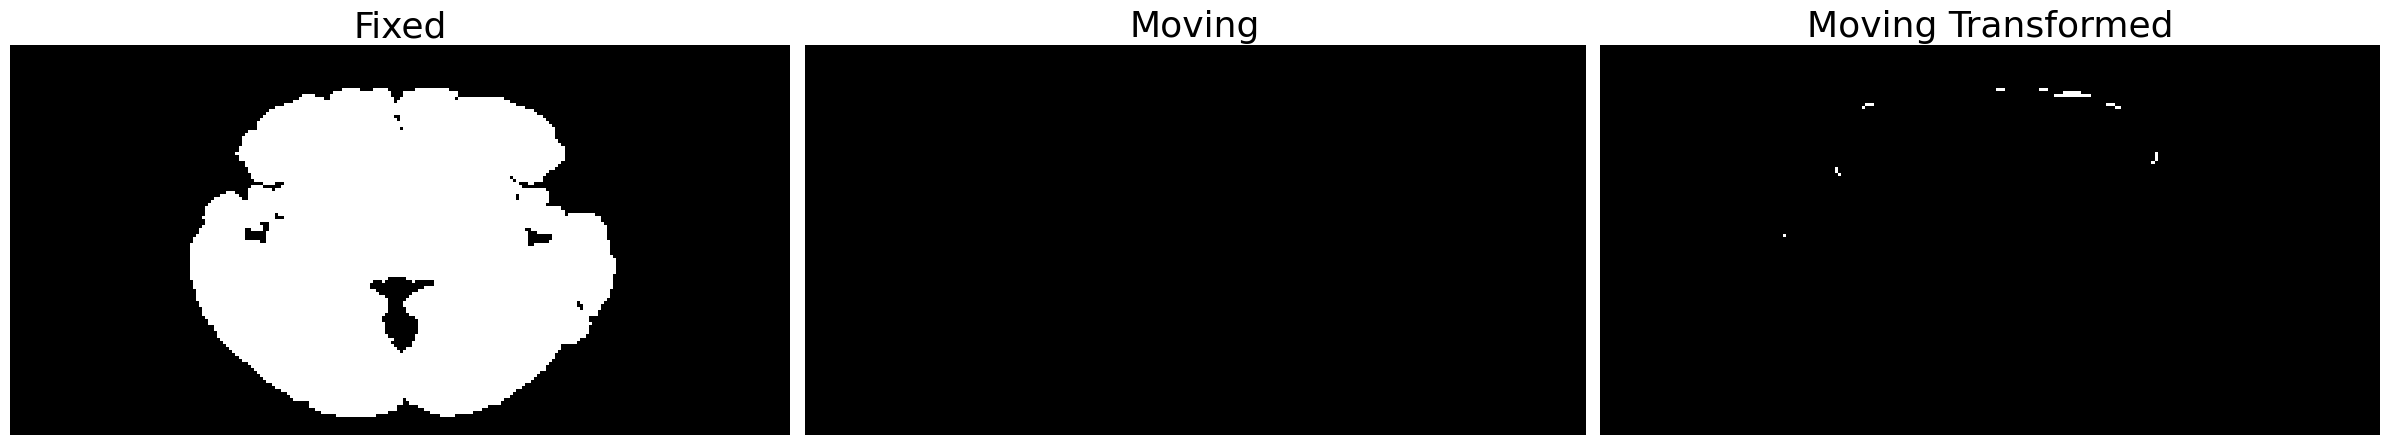

In [23]:
em_segm_sitk = sitk.GetImageFromArray(em_segm)

plot3(em_segm_sitk==1, em_segm_sitk==2, em_segm_sitk == 3)

In [48]:
from sklearn.mixture import GaussianMixture

In [70]:
discr_map_np = sitk.GetArrayFromImage(discr_map)
val_img_np = sitk.GetArrayFromImage(val_img)
weights_init = np.asarray([(discr_map_np == l).sum()/(discr_map_np!=0).sum() for l in [1, 2, 3]])
means_init = np.asarray([[val_img_np[discr_map_np == l].mean() for l in [1, 2, 3]]]).T

precisions_init = np.asarray([np.cov(val_img_np[discr_map_np == l]) for l in [1, 2, 3]]).reshape(3, 1, 1)

In [81]:
gm = GaussianMixture(n_components=3,
                     covariance_type='full',
                     max_iter=1000, n_init=10,
                     random_state=0,
                     weights_init=weights_init,
                     means_init=means_init,
                     precisions_init=precisions_init,)

pred_labels = gm.fit_predict(val_img_np[val_img_np != 0].reshape(-1, 1))

In [82]:
em_pred = np.zeros_like(val_img_np)
em_pred[val_img_np != 0] = pred_labels + 1
EM.compute_dice(sitk.GetArrayFromImage(val_segmentation), em_pred)

{'CSF': 0.2094066860756952, 'WM': 0.848974666049511, 'GM': 0.8391518693456169}

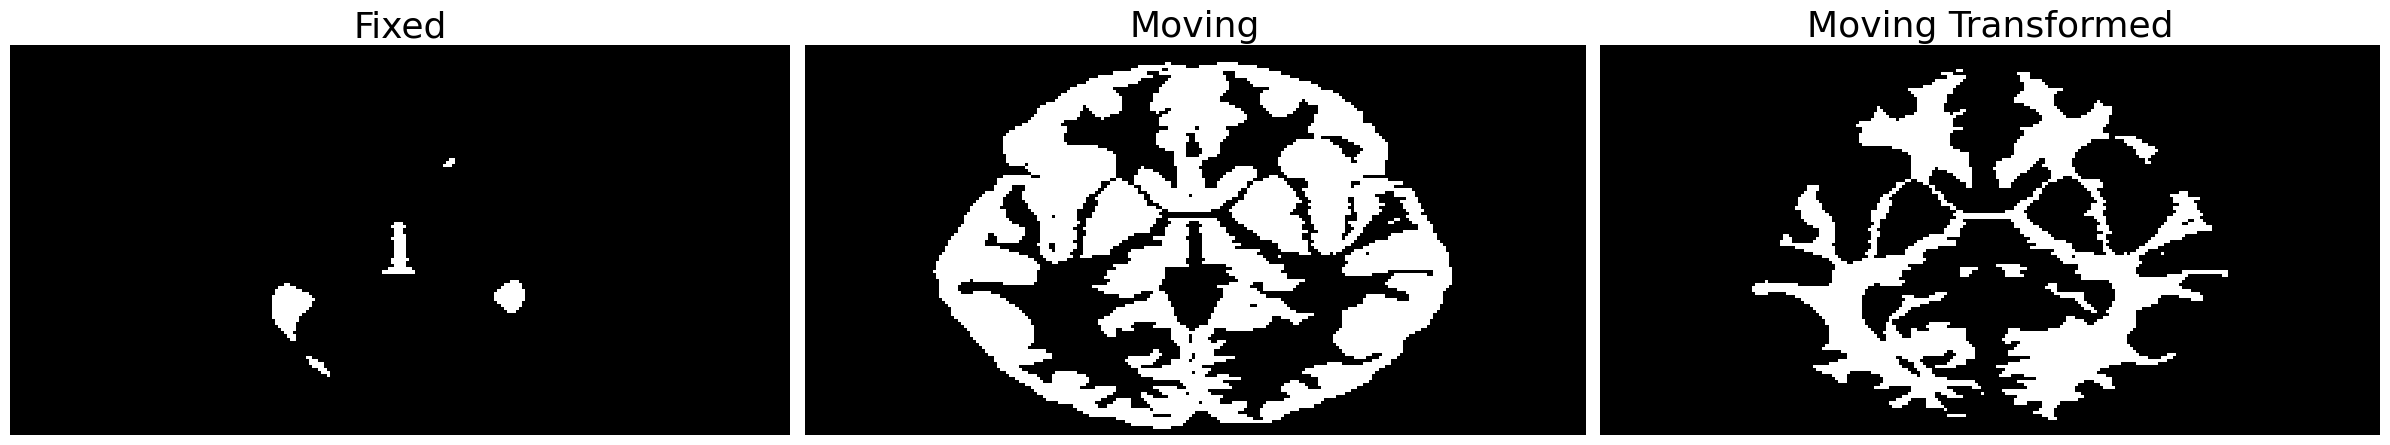

In [83]:
plot3(val_segmentation==1, val_segmentation==2, val_segmentation==3)

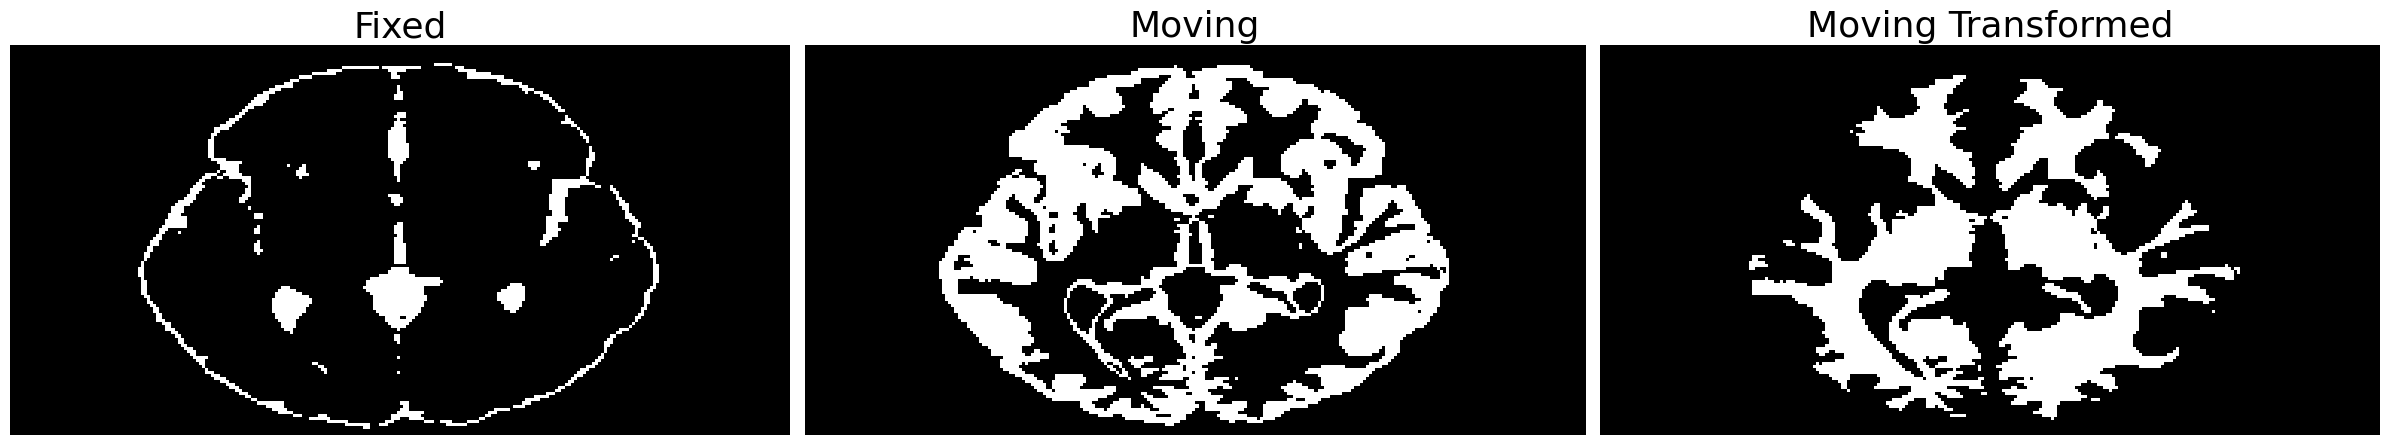

In [84]:
t = sitk.GetImageFromArray(em_pred.astype(np.int16))
plot3(t==1, t==2, t==3)

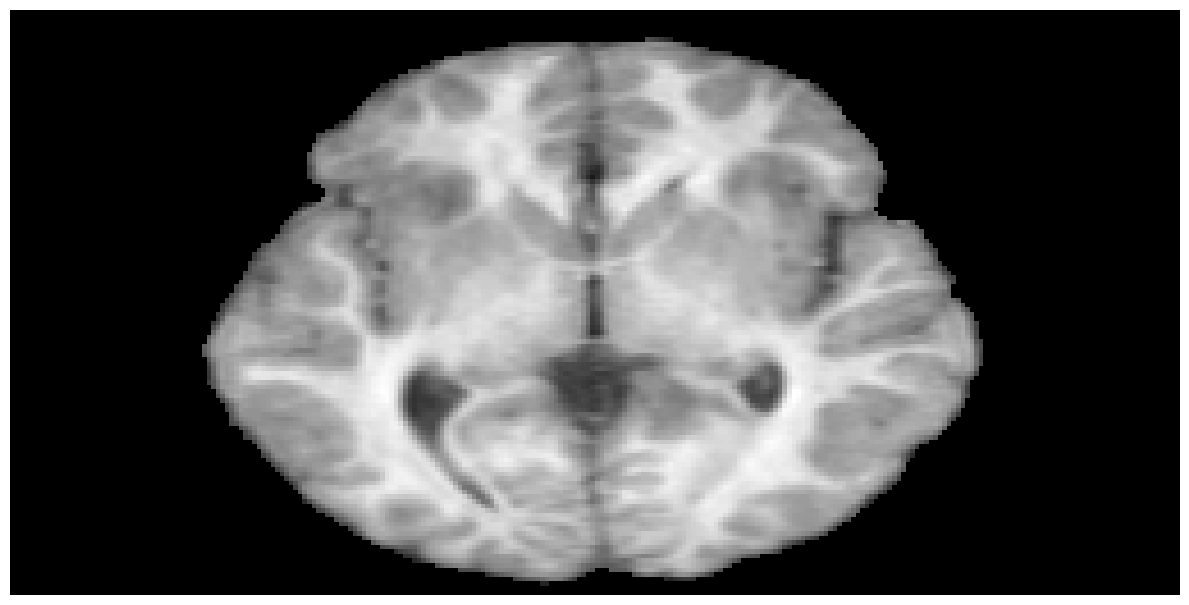

In [87]:
plot1(val_img)